In [41]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

Diagram of all the bus stops located in Kingston 

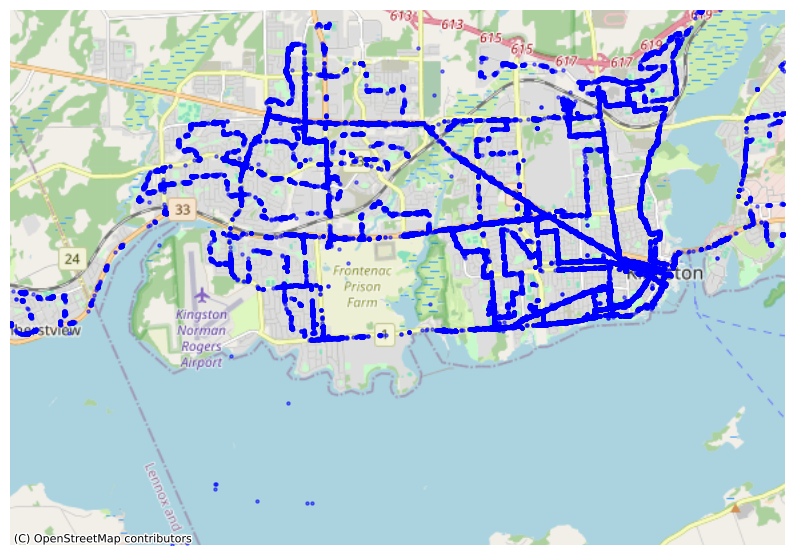

In [63]:
file_path = 'TransitData.csv'
data = pd.read_csv(file_path)
data = data[(data['Latitude'] != 0) & (data['Longitude'] != 0)]
lat_min, lat_max = 44.180, 44.300
lon_min, lon_max = -76.650, -76.450

data = data[(data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) & 
            (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)]

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf.crs = 'EPSG:4326'  # Set coordinate reference system to WGS 84

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=5, alpha=0.5)  # Convert to Web Mercator

# Define the map boundaries for Kingston, Ontario
xlim = ([min(gdf.to_crs(epsg=3857).geometry.x),
         max(gdf.to_crs(epsg=3857).geometry.x)])
ylim = ([min(gdf.to_crs(epsg=3857).geometry.y),
         max(gdf.to_crs(epsg=3857).geometry.y)])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Add map basemap
ax.set_axis_off()
plt.show()

Checking to find bus stops that are within less than 500 meters of a house and serving a total of 20 or less houses 

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'houses_with_nearest_bus_stops.csv' 
df = pd.read_csv(file_path)


distance_threshold = 500
close_driveways = df[df['distance_to_nearest_bus_stop_m'] <= distance_threshold]

# Count driveways close to each bus stop
close_counts = close_driveways['nearest_bus_stop_index'].value_counts()


bus_stops_2_or_less = close_counts[close_counts <= 2].index.tolist()


total_counts = df['nearest_bus_stop_index'].value_counts()

# Bus stops serving < 20 houses
bus_stops_less_than_20 = total_counts[total_counts < 20].index.tolist()

# Find bus stops that are in both lists
common_bus_stops = list(set(bus_stops_2_or_less) & set(bus_stops_less_than_20))


bus_stops_to_plot = df[df['nearest_bus_stop_index'].isin(common_bus_stops)]

# Print total count of unique bus stops meeting criteria
print(f"Total unique bus stops meeting criteria: {len(common_bus_stops)}")


Total unique bus stops meeting criteria: 27


Listing those bus stations 

In [ ]:
import pandas as pd


file_path = 'houses_with_nearest_bus_stops.csv'  
df = pd.read_csv(file_path)

distance_threshold = 500
close_driveways = df[df['distance_to_nearest_bus_stop_m'] <= distance_threshold]

# Count driveways close to each bus stop
close_counts = close_driveways['nearest_bus_stop_index'].value_counts()

# Bus stops serving <= 2 driveways within threshold
bus_stops_2_or_less = close_counts[close_counts <= 2].index.tolist()

# Count total houses served by each bus stop regardless of distance
total_counts = df['nearest_bus_stop_index'].value_counts()

# Bus stops serving < 20 houses
bus_stops_less_than_20 = total_counts[total_counts < 20].index.tolist()

common_bus_stops = list(set(bus_stops_2_or_less) & set(bus_stops_less_than_20))


bus_stops_details = df[df['nearest_bus_stop_index'].isin(common_bus_stops)][['nearest_bus_stop_index']].drop_duplicates()

print(f"Total unique bus stops meeting criteria: {len(common_bus_stops)}")
print("Bus Stops Details (ID):")
print(bus_stops_details.to_string(index=False))
bus_stops_details['nearest_bus_stop_index'].drop_duplicates().to_csv('unique_bus_stop_ids.csv', index=False)

Total unique bus stops meeting criteria: 27
Bus Stops Details (ID):
 nearest_bus_stop_index
                    381
                     29
                    415
                    566
                    535
                    691
                    688
                    132
                    279
                    821
                    276
                    288
                    694
                    574
                    537
                    231
                    681
                    757
                    394
                    776
                    775
                     31
                    662
                    383
                    690
                    829
                    561


In [ ]:
bus_stops_df = pd.read_csv('busstops.csv')
df = pd.DataFrame(bus_stops_df)
# Remove leading zeros and letters
df['ID'] = df['ID'].str.replace('^[0\D]+', '', regex=True)
df.to_csv('busstops.csv', index=False)
print(df)

       ID  Code                                            Name   
0    2077   NaN      Cataraqui Centre Transfer Point Platform 1  \
1     842   NaN         O'Connor Drive (east side of Gardiners)   
2     841   NaN           Norris Court (east side of Gardiners)   
3     848   NaN          640 Cataraqui Woods Drive (south side)   
4     856   NaN             1341 Crossfield Avenue (south side)   
..    ...   ...                                             ...   
825  9105   NaN  Midland Avenue (north side of Cataraqui Woods)   
826  9107   NaN   Juniper Drive (north side of Cataraqui Woods)   
827   445   NaN     First Canada Avenue (West side of Division)   
828   782   NaN           Warne Crescent (south side of Dalton)   
829   783   NaN      Lappan's Lane (north side of John Counter)   

                             Coordinates  Description  Zone ID  URL   
0                    44.25508, -76.57215          NaN      NaN  NaN  \
1                    44.25971, -76.56851          NaN

Checking to see if these stops match the general list of kingston bus stops

In [53]:
# Ensure the 'ID' column in bus_stops_df is the correct type, matching the 'bus_stop_id' column in unique_bus_stop_ids
bus_stops = pd.read_csv('busstops.csv')
unique_bus_stop_ids = pd.read_csv('unique_bus_stop_ids.csv')
bus_stops_df['ID'] = bus_stops_df['ID'].astype(str)
unique_bus_stop_ids['bus_stop_id'] = unique_bus_stop_ids['bus_stop_id'].astype(str)

# Now, perform the filter operation
filtered_bus_stops = bus_stops_df[bus_stops_df['ID'].isin(unique_bus_stop_ids['bus_stop_id'])]

# Check if filtered_bus_stops is empty
if filtered_bus_stops.empty:
    print("No bus stops match the criteria after filtering.")
else:
    print(f"Filtered bus stops: {len(filtered_bus_stops)}")

bus_stops_df[['Longitude', 'Latitude']] = bus_stops_df['LongLat'].str.strip().str.split(',', expand=True)
bus_stops_df['Longitude'] = pd.to_numeric(bus_stops_df['Longitude'].str.strip(), errors='coerce')
bus_stops_df['Latitude'] = pd.to_numeric(bus_stops_df['Latitude'].str.strip(), errors='coerce')

Filtered bus stops: 20


In [56]:
import pandas as pd

# Load the CSV files
bus_stops = pd.read_csv('busstops.csv')  #
unique_bus_stop_ids = pd.read_csv('unique_bus_stop_ids.csv')  


bus_stops['ID'] = bus_stops['ID'].astype(str)
unique_bus_stop_ids['bus_stop_id'] = unique_bus_stop_ids['bus_stop_id'].astype(str)


filtered_bus_stops = bus_stops[bus_stops['ID'].isin(unique_bus_stop_ids['bus_stop_id'])]


if filtered_bus_stops.empty:
    print("No bus stops match the criteria after filtering.")
else:

    filtered_bus_stops[['Longitude', 'Latitude']] = filtered_bus_stops['Coordinates'].str.split(',', expand=True)
    

    filtered_bus_stops['Longitude'] = pd.to_numeric(filtered_bus_stops['Longitude'], errors='coerce')
    filtered_bus_stops['Latitude'] = pd.to_numeric(filtered_bus_stops['Latitude'], errors='coerce')
    
    filtered_bus_stops.to_csv('filtered_bus_stops.csv', columns=['ID', 'Longitude', 'Latitude'], index=False)
    
    print(f"Filtered bus stops saved to 'filtered_bus_stops.csv'. Total bus stops: {len(filtered_bus_stops)}")


Filtered bus stops saved to 'filtered_bus_stops.csv'. Total bus stops: 20


/var/folders/ym/0_vtz1kx4_5fl0q9222rj5n40000gn/T/ipykernel_23865/3797728395.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_stops[['Longitude', 'Latitude']] = filtered_bus_stops['Coordinates'].str.split(',', expand=True)
/var/folders/ym/0_vtz1kx4_5fl0q9222rj5n40000gn/T/ipykernel_23865/3797728395.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_stops[['Longitude', 'Latitude']] = filtered_bus_stops['Coordinates'].str.split(',', expand=True)
/var/folders/ym/0_vtz1kx4_5fl0q922

In [67]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


file_path = 'filtered_bus_stops.csv'
data = pd.read_csv(file_path)
display(data)




,ID,Longitude,Latitude
0,415,44.22134,-76.50893
1,662,44.25521,-76.58668
2,537,44.21842,-76.56733
3,681,44.24849,-76.60266
4,694,44.26656,-76.57826
5,31,44.23743,-76.59217
6,383,44.24531,-76.52038
7,381,44.24697,-76.52383
8,231,44.24371,-76.49515
9,288,44.24093,-76.49485


Displaying those 20 bus stops on a map of Kingston Ontario 

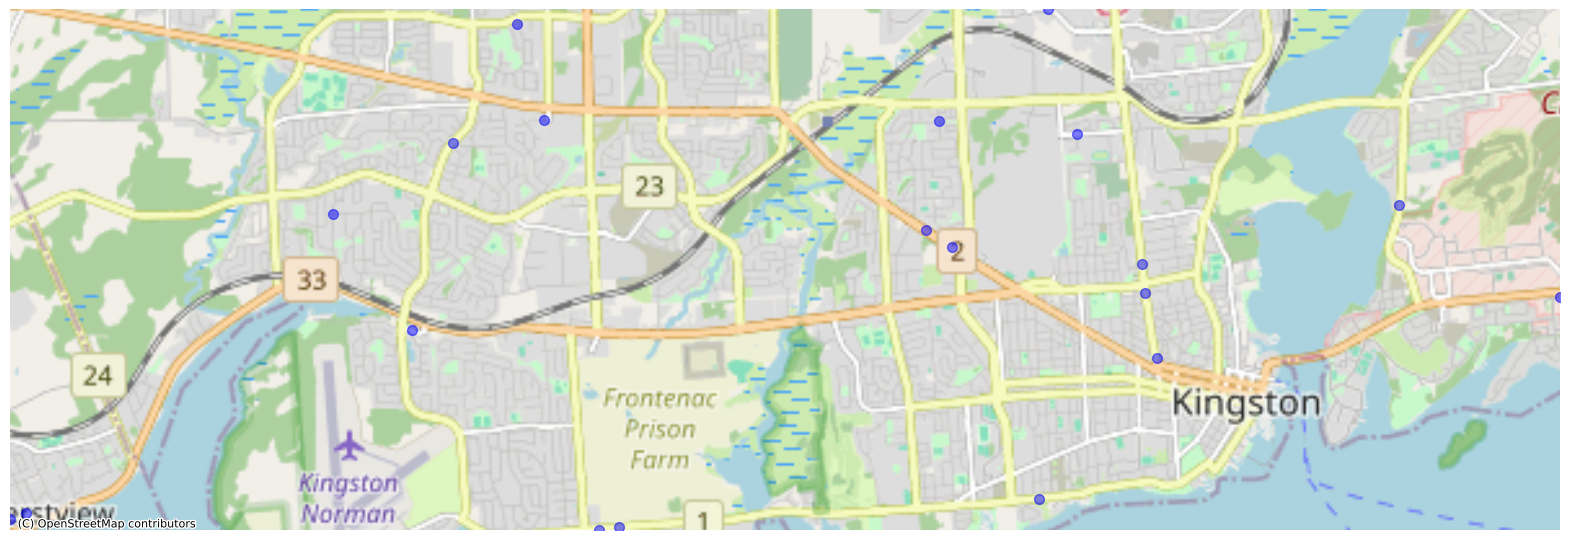

In [83]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


filtered_bus_stops = filtered_bus_stops.rename(columns={"Longitude": "Latitude", "Latitude": "Longitude"})


gdf = gpd.GeoDataFrame(filtered_bus_stops, geometry=gpd.points_from_xy(filtered_bus_stops.Longitude, filtered_bus_stops.Latitude))
gdf.crs = 'EPSG:4326'  


lat_min, lat_max = 41.180, 47.300
lon_min, lon_max = -73.650, -79.450

# Filter for Kingston's geographical bounds
gdf = gdf.cx[lon_min:lon_max, lat_min:lat_max]

# Plot
fig, ax = plt.subplots(figsize=(20, 20))
gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=50, alpha=0.5)  

# Define the map boundaries for Kingston, Ontario, based on the filtered GeoDataFrame
xlim = ([min(gdf.to_crs(epsg=3857).geometry.x), max(gdf.to_crs(epsg=3857).geometry.x)])
ylim = ([min(gdf.to_crs(epsg=3857).geometry.y), max(gdf.to_crs(epsg=3857).geometry.y)])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()
